<a href="https://colab.research.google.com/github/CD-AC/DataEnginner-Streaming_ECommerce/blob/main/Streaming_Ecomerce_Kafka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

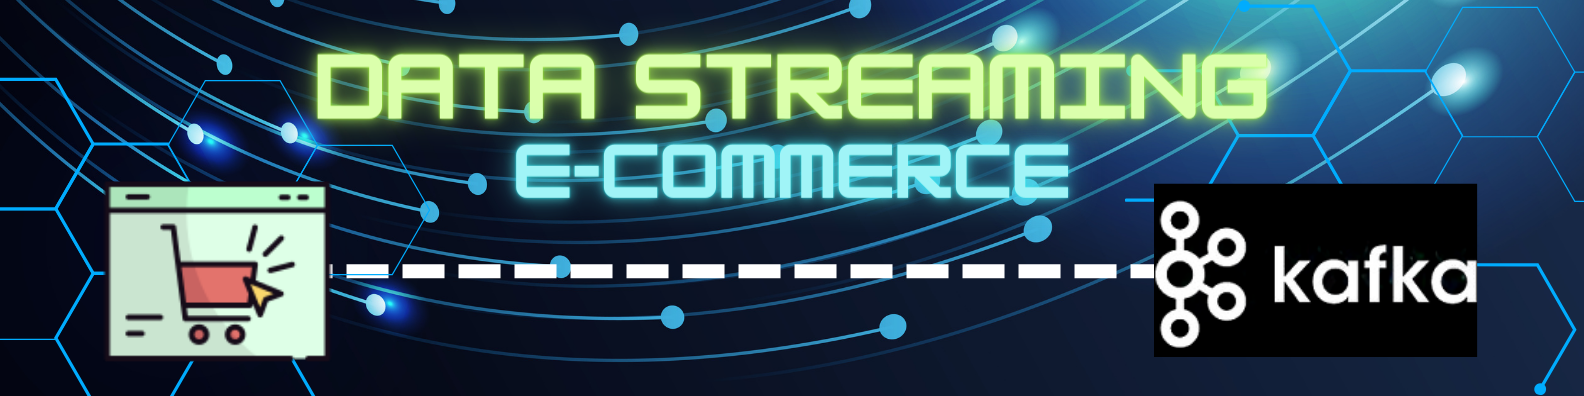

# Libraries

In [ ]:
!pip install kafka-python
!pip install confluent-kafka

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.5/246.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 10.7 MB/s eta 0:00:00


# Import Dependencies

In [ ]:
import pandas as pd
import json
import random
import time
import hashlib


from kafka import KafkaProducer
from confluent_kafka import Producer
import socket
import json
import os

from kafka_auth import confi

# Purchase Simulation

In [ ]:
cities = ['Bogotá','Medellín','Cali','Bucaramanga','Barranquilla']
payment_online = ['Credit_card','PSE']
payment_store = ['Cash','Nequi','Daviplata','Credit_card']
source = ['Facebook','Instagram','Organic','Twitter','Influencer_1','Influencer_2','Influencer_3','Influencer_4']
status_purchase = ['COMPLETED','FAILED_CHECKOUT','FAILED_API_RESPONSE','INSUFICCIENT_FUNDS','COMPLETED','COMPLETED','COMPLETED','COMPLETED','COMPLETED','COMPLETED','FAILED_API_RESPONSE','INSUFICCIENT_FUNDS','USER_ERROR','FRAUD','COMPLETED','COMPLETED','COMPLETED']

In [ ]:
bog_coords = [(4.651600960108946, -74.12628850377475),(4.661984763443271, -74.13466548843223),(4.647569693587232, -74.10186525959672)]
buc_coords = [(7.099917472863198, -73.10730617492302),(7.07243688331635, -73.10525936227518)]
cali_coords = [(3.4287786094866717, -76.53749228193497),(3.4148803158142966, -76.54041613631288),(3.4164091379805432, -76.54751692551635)]
bar_coords = [(11.014167139030025, -74.82747678131524),(11.004041676077495, -74.83545204769058),(10.990580146449894, -74.78876005521157)]
mede_coords = [(6.163315879042265, -75.6052691935286),(6.17784573272914, -75.59141059178306),(6.198053256721469, -75.5733524126965)]

# Funtion Simulation Pay Method

In [ ]:
def get_pay_method(source,status_purchase,payment_online,payment_store):

    if source == 'Organic':

        payment = random.choice(payment_store)
        status = 'COMPLETED'
        order_type = 'STORE'

    elif source != 'Organic':

        payment = random.choice(payment_online)
        status = random.choice(status_purchase)
        order_type = 'ONLINE'

    return payment,status,order_type



def get_coords(city):

    if city == 'Bogotá':
        coords = random.choice(bog_coords)
    elif city == 'Bucaramanga':
        coords = random.choice(buc_coords)
    elif city == 'Cali':
        coords = random.choice(cali_coords)
    elif city == 'Barranquilla':
        coords = random.choice(bar_coords)
    elif city == 'Medellín':
        coords = random.choice(mede_coords)

    return coords

In [ ]:
pay = get_pay_method('Organic',status_purchase,payment_online,payment_store)
print(pay)

('Nequi', 'COMPLETED', 'STORE')


In [ ]:
pay[0]

'Nequi'

In [ ]:
pay[1]

'COMPLETED'

In [ ]:
random.choice(cities)

'Medellín'

In [ ]:
hola = random.choice(cities)
print(f' Ciudad  >> {hola}')
print(f' Coordenadas >> {get_coords(hola)}')

 Ciudad  >> Bogotá
 Coordenadas >> (4.661984763443271, -74.13466548843223)


# Import Products E-Commerce

In [3]:
df = pd.read_excel('products.xlsx')

In [4]:
df

,PRODUCT_NAME,PRICING,COMISION,BRAND,CATEGORY
0,Laptop_Acer_Nitro_5_4GB,1350000,0.20,Acer,LAPTOPS
1,Laptop_Acer_Nitro_5_8GB,2550000,0.25,Acer,LAPTOPS
2,Laptop_Acer_Nitro_5_16GB,3500000,0.30,Acer,LAPTOPS
3,Laptop_Acer_Predator_32GB,4800000,0.35,Acer,GAMING
4,Laptop_Asus_VivoBook_4GB,1150000,0.15,Asus,LAPTOPS
5,Laptop_Asus_VivoBook_8GB,1850000,0.18,Asus,LAPTOPS
6,Laptop_Asus_Zephyrus_16GB,3890000,0.20,Asus,LAPTOPS
7,Laptop_Asus_Zephyrus_32GB,6990000,0.25,Asus,GAMING
8,Laptop_Lenovo_IdeaPad_4GB,1850000,0.20,Lenovo,LAPTOPS
9,Laptop_Lenovo_IdeaPad_8GB,3199000,0.28,Lenovo,LAPTOPS


# Config Kafka Cluster

In [ ]:
confi

{'bootstrap.servers': 'pkc-p11xm.us-east-1.aws.confluent.cloud:9092',
 'security.protocol': 'SASL_SSL',
 'sasl.mechanisms': 'PLAIN',
 'sasl.username': '5UL6HXDA76UMV2XO',
 'sasl.password': 'moHEUJWiATAvKwrIB1PJfLMe9KcCVFRuFRAPc/guH9MC+199EJJnfAkLIondSJDA'}

In [ ]:
producer = Producer(confi)

# Send Message To Kafka Topic

In [ ]:
delivered_records = 0
topic = 'topic_druid_rt'

x = 1

data_purchase = []

while(x > 0):

    date = pd.to_datetime('today').strftime("%Y-%m-%d %H:%M:%S")

    product = df['PRODUCT_NAME '][random.randint(0,14)]
    pricing =  df[df['PRODUCT_NAME ']==product]['PRICING'].values[0]
    comision =  df[df['PRODUCT_NAME ']==product]['COMISION'].values[0]
    brand = df[df['PRODUCT_NAME ']==product]['BRAND'].values[0]
    category = df[df['PRODUCT_NAME ']==product]['CATEGORY'].values[0]
    source_temp = random.choice(source)
    pay = get_pay_method(source_temp,status_purchase,payment_online,payment_store)
    city = random.choice(cities)

    purchase = {'purchase_ID': str(hashlib.sha256(f"{x} {product} {pricing} {comision} {date} {source_temp} {pay[1]}".encode('utf-8')).hexdigest())[:10],
            'Product_name' : product,
            'Pricing':str(pricing),
            'Comision':str(comision),
            'Revenue' : str(round(pricing*comision,2)),
            'Payment_Mehtod':pay[0],
            'Status' : pay[1],
            'Order_Type' : pay[2],
            'City':city,
            'Location': str(get_coords(city)), #[get_coords(city)],
            'Latitud' : str(get_coords(city)[0]) ,
            'Longitud' :  str(get_coords(city)[1]),
            'Source':source_temp,
            'Brand' : brand,
            'Category': category,
            'Created_at': date}


    #data_purchase.append(pd.DataFrame(purchase))

    record_key = "Purchase_simulator"
    record_value =  json.dumps(purchase).encode('utf-8')
    print("Producing record: {}\t{}".format(record_key, record_value))
    producer.produce(topic, key=record_key, value=record_value)
    producer.poll(0)
    delivered_records += 1
    x += 1

    time.sleep(random.choice([1,1.5]))




producer.flush()

print('\n')
print('\n')
print("{} messages were produced to topic {}!".format(delivered_records, topic))
print('\n')
print('\n')

Producing record: Purchase_simulator	b'{"purchase_ID": "ea0f5bbe7b", "Product_name": "Laptop_Brand3_8GB", "Pricing": "3199000", "Comision": "0.28", "Revenue": "895720.0", "Payment_Mehtod": "Nequi", "Status": "COMPLETED", "Order_Type": "STORE", "City": "Cali", "Location": "(3.4164091379805432, -76.54751692551635)", "Latitud": "3.4148803158142966", "Longitud": "-76.53749228193497", "Source": "Organic", "Brand": "Brand3", "Category": "LAPTOPS", "Created_at": "2024-03-27 23:47:06"}'
Producing record: Purchase_simulator	b'{"purchase_ID": "71ca926031", "Product_name": "Console_PS5", "Pricing": "3560000", "Comision": "0.3", "Revenue": "1068000.0", "Payment_Mehtod": "Credit_card", "Status": "FAILED_CHECKOUT", "Order_Type": "ONLINE", "City": "Bucaramanga", "Location": "(7.099917472863198, -73.10730617492302)", "Latitud": "7.099917472863198", "Longitud": "-73.10730617492302", "Source": "Influencer_1", "Brand": "PS5", "Category": "VIDEO GAMES", "Created_at": "2024-03-27 23:47:07"}'
Producing reco

KeyboardInterrupt: 

In [ ]:
print('\n')
print('\n')
print("{} messages were produced to topic {}!".format(delivered_records, topic))
print('\n')
print('\n')





88 messages were produced to topic topic_druid_grafana!




